**Create quantizised version of GPT-2 and save the memory =)**

Egor Shvetsov, Viktoriia Chekalina

In [1]:
! pip install transformers

In [1]:
device = 'cuda:0'

## Class Quantizator

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

![](https://drive.google.com/uc?export=view&id=1qG2l66t1tZNk-V-CQs80e-DiyevAF2ea)

In [3]:
class Quantizer(nn.Module):
    def __init__(self, bit):

        super(Quantizer, self).__init__()
        self.bit = bit
        self.thd_neg = -(2 ** (bit - 1))
        self.thd_pos = 2 ** (bit - 1) - 1
        self.s = nn.Parameter(torch.ones(1))

    def init_from(self, x):
        s = (x.max() - x.min()) / (self.thd_pos - self.thd_neg )
        self.s = nn.Parameter(s)

    def skip_grad_scale(self,x, scale):
        y = x
        y_grad = x * scale
        return (y - y_grad).detach() + y_grad

    def round_pass(self, x): # round ans clip are not differentiable
        y = x.round()
        y_grad = x
        return (y - y_grad).detach() + y_grad

    def forward(self, x):
        if self.bit >= 32:
            return x

        s_grad_scale = 1.0 / ((self.thd_pos * x.numel()) ** 0.5) # is not diff, skip_grad_scale

        device = x.device

        s_scale = self.skip_grad_scale(self.s, s_grad_scale).to(device)

        x = x / (s_scale) # go to new space
        x = torch.clamp(x, self.thd_neg, self.thd_pos) # clip is not diff, round_pass
        x = self.round_pass(x) #go back
        x = x * (s_scale)
        return x

In [4]:
vector =(np.arange(-10, 10, 1))**2

In [5]:
vector

array([100,  81,  64,  49,  36,  25,  16,   9,   4,   1,   0,   1,   4,
         9,  16,  25,  36,  49,  64,  81])

In [6]:
quantizer = Quantizer(4)
vector = torch.tensor(vector)
quantizer.init_from(vector)
quantizer(vector).detach().numpy()

array([46.666664 , 46.666664 , 46.666664 , 46.666664 , 33.333332 ,
       26.666666 , 13.333333 ,  6.6666665,  6.6666665,  0.       ,
        0.       ,  0.       ,  6.6666665,  6.6666665, 13.333333 ,
       26.666666 , 33.333332 , 46.666664 , 46.666664 , 46.666664 ],
      dtype=float32)

In [7]:
quantizer.s

Parameter containing:
tensor(6.6667, requires_grad=True)

In [8]:
quantizer = Quantizer(16)
vector = torch.tensor(vector)
quantizer.init_from(vector)
quantizer(vector).detach().numpy()

/tmp/ipykernel_1883355/367059996.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vector = torch.tensor(vector)


array([49.999237  , 49.999237  , 49.999237  , 48.99977   , 36.00061   ,
       25.000381  , 16.00061   ,  8.999771  ,  3.9993896 ,  0.99946594,
        0.        ,  0.99946594,  3.9993896 ,  8.999771  , 16.00061   ,
       25.000381  , 36.00061   , 48.99977   , 49.999237  , 49.999237  ],
      dtype=float32)

In [9]:
quantizer.s

Parameter containing:
tensor(0.0015, requires_grad=True)

<Figure size 1000x700 with 0 Axes>

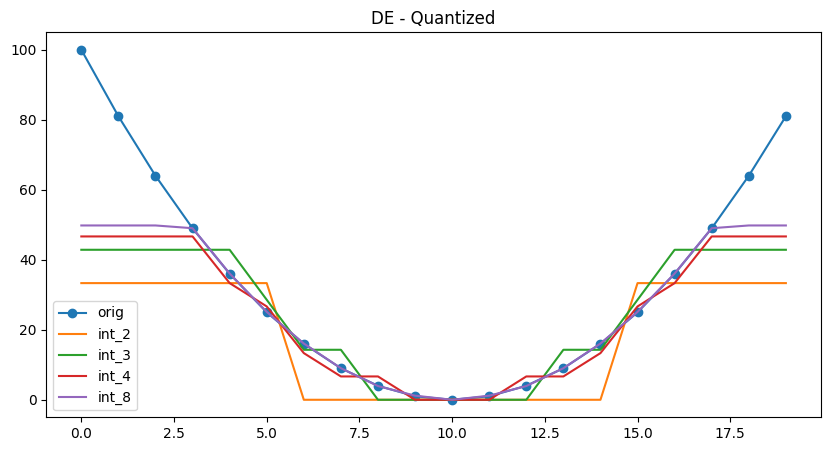

In [10]:
vector =(np.arange(-10, 10, 1))**2

vector = torch.tensor(vector)

plt.figure(figsize=(10,7))

f = plt.figure(figsize = (10, 5))

plt.plot(range(len(vector)), vector,label='orig', marker='o')
for bit in [2,3,4, 8]:
    quantizer = Quantizer(bit)
    quantizer.init_from(vector) # define step
    dequantized = quantizer(vector) #

    dequantized = dequantized.detach().numpy()

    plt.plot(range(len(vector)),dequantized,label=f'int_{bit}')

plt.title('DE - Quantized');
plt.legend();

In [11]:
class QALinear(nn.Module):
    def __init__(self, fc_w, fc_b, bit):
        super(QALinear, self).__init__()
        self.bit = bit
        self.in_features, self.out_features = fc_w.shape
        self.fc = nn.Linear(in_features = self.in_features,
                      out_features = self.out_features,
                      bias = True)
        self.fc.weight = torch.nn.Parameter(torch.t(fc_w))
        self.fc.bias = fc_b
        self.define_q_fucntions(self.bit)


    # can be used to modify bits during the training
    def define_q_fucntions(self, bit):
        self.quantizer_act = Quantizer(bit)
        self.quantizer_weigh = Quantizer(bit)
        self.quantizer_weigh.init_from(self.fc.weight)

        self.quantizer_bias = Quantizer(bit)

    def forward(self, input_x):
        quantized_weight = self.quantizer_weigh(self.fc.weight)
        quantized_bias = self.quantizer_weigh(self.fc.bias)
        quantized_act = self.quantizer_act(input_x)
        out = nn.functional.linear(quantized_act, quantized_weight, bias=quantized_bias) #torch.nn.functional.linear(input, weight, bias)
        return out

# Transformer-based model quantization

### GPT-2 quantization pipeline

1) Extract fully-connected (transformers.conv1D()) from pretrained GPT-2

2) Create quantized QALinear object over it

3) Replace initial fully-connected layer with quantized layer

4) Fine-tune model to recover performance degradation


## Let's go through all of the stages in the pipeline

In [12]:
import numpy as np

In [27]:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel

# Initializing a GPT2 configuration
configuration = GPT2Config()

device = 'cuda'


model = GPT2LMHeadModel(configuration).from_pretrained("gpt2",
                                                return_dict=True,
                                                is_decoder=True)
outt = model.to(device)


We will validate a pre-trained language GPT-2 model on a validation part **Wikitext-103** dataset.

To create a validation dataset we should:
    
- download archieved dataset
- extract it
- wrap tran and test parts in TextDataset and further Dataloader class

In [14]:
!unzip wikitext-103.zip
!ls

unzip:  cannot find or open wikitext-103.zip, wikitext-103.zip.zip or wikitext-103.zip.ZIP.
LICENSE   README.md  quantizied_transformers_2025.ipynb
Lectures  Seminars   wikitext-103


In [31]:
from torch.utils.data import DataLoader, RandomSampler
from transformers import GPT2Tokenizer
from transformers import TextDataset
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")


dataset_valid = TextDataset(tokenizer=tokenizer,
                                #file_path="/home/jovyan/shares/SR004.nfs2/chekalina/transformers-course/wikitext-103/wiki.valid.tokens",
                                file_path="/content/wikitext-103/wiki.valid.tokens",
                                block_size=512)


dataset_test = TextDataset(tokenizer=tokenizer,
                               #file_path="/home/jovyan/shares/SR004.nfs2/chekalina/transformers-course/wikitext-103/wiki.test.tokens",
                               file_path="/content/wikitext-103/wiki.test.tokens", 
                               block_size=512)
print (len(dataset_valid), len(dataset_test))

eval_dataloader = DataLoader(dataset_test, batch_size=10)

487 557


Validate model and calculate a perplexity:

In [32]:
from tqdm import tqdm
model.eval()
import torch

device = 'cuda'

def evaluate(model):
    losses = []
    eval_loss = 0.0
    perplexity = 0.0
    nb_eval_steps = 0
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
            perplexity += torch.exp(torch.tensor(eval_loss))
            losses.append(eval_loss)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps

    perplexity = torch.exp(torch.tensor(eval_loss))
    perplexity = perplexity
    return perplexity

In [33]:
perplexity = evaluate(model.to(device))
perplexity

Evaluating: 100%|██████████| 56/56 [00:05<00:00, 10.63it/s]


tensor(33.9500)

In [34]:
model.transformer.h[1].mlp.c_fc.weight.shape

torch.Size([768, 3072])

Let's generate text to ensure that model is good.

In [35]:
seq_len = 512

In [36]:
i = 0
for batch_idx, sample in tqdm(enumerate(eval_dataloader)):
    input_ids, label_ids = sample[:seq_len - 1], sample[0][1:seq_len]
    input_ids = input_ids.to(device=device)
    label_ids = label_ids.to(device=device)
    outputs = model(input_ids)
    print ("\n")
    print("input_ids[0][-20:]", tokenizer.decode(input_ids[0][-10:]))
    print ("\n")
    print("label_ids[0][-21:]", tokenizer.decode(input_ids[0][-9:]))
    print ("\n")
    print("output", tokenizer.decode(outputs.logits[0].argmax(dim=-1)[-10:]))
    #print("GENERATED", tokenizer.decode(outputs.logits.argmax(dim=-1)[0][-1:]))
    print("\n\n\n")
    i += 1
    if i > 10: break
    print ("\n\n")

2it [00:00, 10.85it/s]



input_ids[0][-20:]  he received critical reviews in The Herald , and Evening


label_ids[0][-21:]  received critical reviews in The Herald , and Evening


output  was a acclaim for the Independent Sun The in Standard









input_ids[0][-20:]  Fu 's poetry has made a profound impact on


label_ids[0][-21:]  's poetry has made a profound impact on


output  's influence is been him significant impact on Japanese











4it [00:00, 10.83it/s]

input_ids[0][-20:]  100 @.@ 0 lb ) shells used in


label_ids[0][-21:]  @.@ 0 lb ) shells used in


output  @.@ 5. ) guns fired in the









input_ids[0][-20:]  other battleships and a pair of light cruisers


label_ids[0][-21:]  battleships and a pair of light cruisers


output  Japanesehips, a destroyer of destroy cruisers ,









input_ids[0][-20:]  . A station on the latter island reported a pressure


label_ids[0][-21:]  A station on the latter island reported a pressure


output  The few in the island island reported a bar of











8it [00:00, 10.84it/s]

input_ids[0][-20:]  prepared to set up their weapons . 
 By


label_ids[0][-21:]  to set up their weapons . 
 By


output  to move fire their fire . 
The the









input_ids[0][-20:]  site . At the ferry site the North Koreans had


label_ids[0][-21:]  . At the ferry site the North Koreans had


output  . The the time crossing the North Koreans had been









input_ids[0][-20:]  released their first live album , The D.I


label_ids[0][-21:]  their first live album , The D.I


output  the fifth studio album, The LastrownO.











10it [00:01,  9.84it/s]

input_ids[0][-20:]  victory won by Austria established it as the predominant naval


label_ids[0][-21:]  won by Austria established it as the predominant naval


output  of by the in the as the most naval power









input_ids[0][-20:]  and little else . An ingenious arrangement of cork


label_ids[0][-21:]  little else . An ingenious arrangement of cork


output  the else .
 ' solution of theablinged









input_ids[0][-20:]  get rid of <unk> for two reasons .


label_ids[0][-21:]  rid of <unk> for two reasons .


output  rid of theunk> Lat the reasons. One






In [37]:
for i in [6, 8, 9, 10, 11]:
    # fc part
    fc_w = model.transformer.h[i].mlp.c_fc
    fp_w = model.transformer.h[i].mlp.c_proj
    model.transformer.h[i].mlp.c_fc = QALinear(fc_w.weight, fc_w.bias, 4)
    model.transformer.h[i].mlp.c_proj = QALinear(fp_w.weight, fp_w.bias, 4)

In [38]:
perplexity = evaluate(model)
perplexity

Evaluating: 100%|██████████| 56/56 [00:05<00:00, 10.14it/s]


tensor(135.2817)

### Fine-tune the model

In [41]:
train_dataloader = DataLoader(dataset_valid, batch_size=4)

In [42]:
from transformers import get_cosine_schedule_with_warmup

In [ ]:
epochs = 20
gradient_accumulation_steps = 10
num_train_batches = len(train_dataloader)
cross_entropy = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.eos_token_id)
training_steps = num_train_batches // gradient_accumulation_steps * epochs
optimizer = torch.optim.Adam(model.parameters(), lr=1.25e-4)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=800, num_training_steps=training_steps)


for epoch in range(epochs):

    train_loss = 0
    epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=True)
    for train_batch_idx, item in enumerate(epoch_iterator):
        optimizer.zero_grad() # in case there are unused accumulated gradients

        model.train()
        src, tgt = (item, item)
        src = src.to(device=device)
        tgt = tgt.to(device=device)


        output = model(input_ids=src, labels=tgt)
        loss = output.loss
        train_loss += loss.item() # before gradient accumulation step
        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward() # accumulate gradients

        if train_batch_idx % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()  # Update learning rate schedule
            optimizer.zero_grad()

        if train_batch_idx % 20 == 0:
            print ("loss", loss)
            perplexity = evaluate(model)
            print ("perplexity", perplexity)

loss tensor(0.4072, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(91.4391)
loss tensor(0.4397, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(91.0621)
loss tensor(0.4572, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(91.1543)
loss tensor(0.4405, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(91.2543)
loss tensor(0.4228, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(91.3111)
loss tensor(0.3674, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(91.0018)
loss tensor(0.4579, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(91.1313)
loss tensor(0.4100, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(91.1212)
loss tensor(0.4379, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(90.9600)
loss tensor(0.4527, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(91.4292)
loss tensor(0.4398, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(91.2507)
loss tensor(0.4238, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(90.7740)
loss tensor(0.3701, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(90.6848)
loss tensor(0.4595, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(90.5185)
loss tensor(0.4115, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(90.7691)
loss tensor(0.4306, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(90.5784)
loss tensor(0.4493, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(90.4410)
loss tensor(0.4371, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(90.6689)
loss tensor(0.4225, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(90.1622)
loss tensor(0.3658, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(90.3784)
loss tensor(0.4573, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(90.2045)
loss tensor(0.4077, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(90.1132)
loss tensor(0.4317, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(89.8321)
loss tensor(0.4517, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(90.0218)
loss tensor(0.4333, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(90.1783)
loss tensor(0.4196, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(89.8305)
loss tensor(0.3604, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00, 10.00it/s]


perplexity tensor(90.0467)
loss tensor(0.4543, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(88.8563)
loss tensor(0.4042, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.97it/s]


perplexity tensor(89.4237)
loss tensor(0.4220, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(88.9531)
loss tensor(0.4476, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(88.9502)
loss tensor(0.4331, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(88.9179)
loss tensor(0.4132, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(89.0114)
loss tensor(0.3570, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(89.0529)
loss tensor(0.4480, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(89.1621)
loss tensor(0.4007, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00, 10.00it/s]


perplexity tensor(88.7359)
loss tensor(0.4241, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00, 10.00it/s]


perplexity tensor(88.6842)
loss tensor(0.4405, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(88.4296)
loss tensor(0.4294, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(88.1889)
loss tensor(0.4120, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(88.3743)
loss tensor(0.3530, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(88.3292)
loss tensor(0.4449, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(88.1070)
loss tensor(0.3923, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(87.9671)
loss tensor(0.4134, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00, 10.00it/s]


perplexity tensor(87.7664)
loss tensor(0.4362, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(86.5904)
loss tensor(0.4244, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(86.5595)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(87.0601)
loss tensor(0.3512, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(87.0887)
loss tensor(0.4403, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(87.1412)
loss tensor(0.3909, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(83.5221)
loss tensor(0.4065, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(82.9137)
loss tensor(0.4276, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(81.9969)
loss tensor(0.4146, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.99it/s]


perplexity tensor(81.8861)
loss tensor(0.3945, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(81.5243)
loss tensor(0.3396, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(81.1356)
loss tensor(0.4277, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00, 10.00it/s]


perplexity tensor(80.7198)
loss tensor(0.3771, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00, 10.00it/s]


perplexity tensor(80.7390)
loss tensor(0.4006, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00, 10.00it/s]


perplexity tensor(81.0195)
loss tensor(0.4194, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00, 10.00it/s]


perplexity tensor(80.8843)
loss tensor(0.4082, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(81.0444)
loss tensor(0.3918, device='cuda:0', grad_fn=<DivBackward0>)


Evaluating: 100%|██████████| 56/56 [00:05<00:00,  9.98it/s]


perplexity tensor(81.1850)


In [ ]:
perplexity = evaluate(model)
perplexity